<a href="https://colab.research.google.com/github/diego-oyarce/trabajo-final-ml/blob/main/trabajo_final_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Prueba de ciencia de datos de Empresa SoftWorld

Primero se procede a importar las librerias necesarias para trabajar con los datos y realizar el modelo de aprendizaje automático.

In [7]:
from google.colab import drive
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
from geopy.distance import geodesic
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


Una vez importadas las librerias y funciones se continua con la lectura de archivos. Para esto se utiliza pandas.

In [4]:
orders = pd.read_csv('/content/drive/MyDrive/MachineLearning/orders.csv')
order_products = pd.read_csv('/content/drive/MyDrive/MachineLearning/order_products.csv')
shoppers = pd.read_csv('/content/drive/MyDrive/MachineLearning/shoppers.csv')
store_branch = pd.read_csv('/content/drive/MyDrive/MachineLearning/storebranch.csv')

A continuación, se unen los conjuntos de datos relevantes haciendo uso de las columnas clave.

In [5]:
data = orders.merge(order_products, on='order_id')
data = data.merge(shoppers, on='shopper_id')
data = data.merge(store_branch, on='store_branch_id')

Se calcula la distancia entre la tienda y el lugar de destino del pedido.

In [6]:
def calculate_distance(row):
  store_coords = (row['lat_y'], row['lng_y'])
  destination_coords = (row['lat_x'], row['lng_x'])
  return geodesic(store_coords, destination_coords).kilometers

Se añade una nueva columna a 'data' y se eliminan las columnas 'lat_x', 'lng_x', 'lat_y', 'lng_y'

In [10]:
data['distance_to_store'] = data.apply(calculate_distance, axis=1)
data.drop(columns=['lat_x', 'lng_x', 'lat_y', 'lng_y'], inplace=True)

Se codifican las variables categóricas, en este caso solo 'buy_unit'

In [11]:
data = pd.get_dummies(data, columns=['buy_unit', 'on_demand'])

Ahora se transforma el campo 'promised_time' a valores numéricos que se puedan usar en el modelo.

In [12]:
data['promised_time'] = pd.to_datetime(data['promised_time'])
data['promised_day'] = data['promised_time'].dt.day
data['promised_month'] = data['promised_time'].dt.month
data['promised_dayofweek'] = data['promised_time'].dt.dayofweek
data['promised_hour'] = data['promised_time'].dt.hour

Se transforma  columna 'seniority' a valores numéricos integrando una nueva columna 'seniority_encoded'. Luego se elimina la columna 'seniority'.

In [13]:
label_encoder = LabelEncoder()
data['seniority_encoded'] = label_encoder.fit_transform(data['seniority'])
data.drop(columns=['seniority'], inplace=True)

Para continuar, se eliminan las filas con datos faltantes.

In [14]:
data.dropna(inplace=True)

Se seleccionan las características relevantes para el modelo.

In [16]:
features = ['order_id', 'promised_time', 'shopper_id', 'store_branch_id', 'product_id', 'quantity', 'found_rate', 'picking_speed', 'accepted_rate', 'rating', 'store_id', 'distance_to_store', 'buy_unit_KG', 'buy_unit_UN', 'on_demand_False', 'on_demand_True', 'promised_day', 'promised_month', 'promised_dayofweek', 'promised_hour', 'seniority_encoded']
target = 'total_minutes'

Distribución de la variable objetivo 'total_minutes'

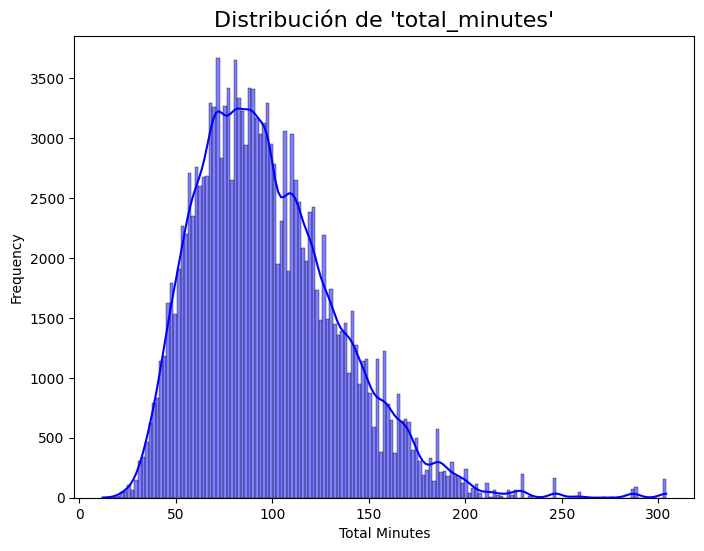

In [17]:
plt.figure(figsize=(8, 6))
sns.histplot(data['total_minutes'], kde=True, color='blue')
plt.title("Distribución de 'total_minutes'", fontsize=16)
plt.xlabel('Total Minutes')
plt.ylabel('Frequency')
plt.show()

Correlación entre 'total_minutes' y las otras variables.

<ipython-input-19-4f1dd546dca3>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlation_matrix = data.corr()


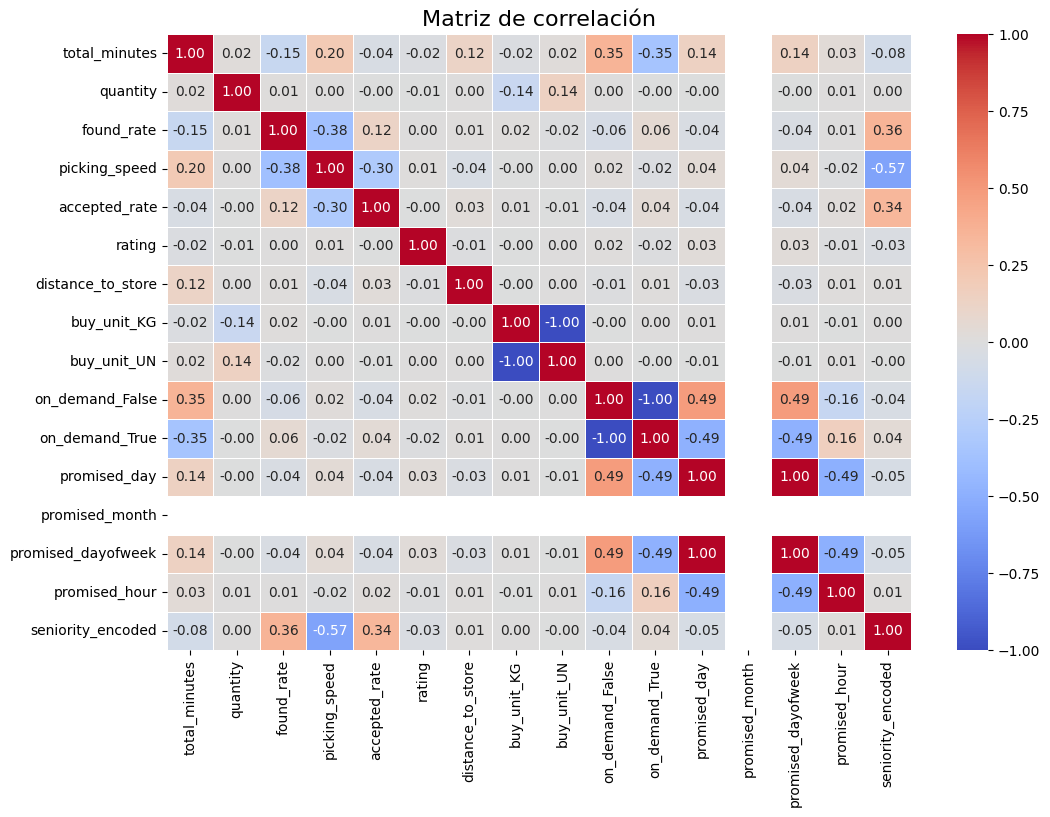

In [19]:
correlation_matrix = data.corr()
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de correlación", fontsize=16)
plt.show()

Se calcula la correlación que tienen las variables con 'total_minutes' y se eliminan las columnas que presenten una correlación por debajo del umbral establecido, en este caso el umbral se establece en 0.1

In [20]:
correlations = data.corr()['total_minutes'].abs()
umbral = 0.1
low_corr_columns = correlations[correlations < umbral].index
data.drop(columns=low_corr_columns, inplace=True)
print(data.columns)

<ipython-input-20-bd2e2413f2b8>:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  correlations = data.corr()['total_minutes'].abs()


Index(['order_id', 'promised_time', 'shopper_id', 'store_branch_id',
       'total_minutes', 'product_id', 'found_rate', 'picking_speed',
       'store_id', 'distance_to_store', 'on_demand_False', 'on_demand_True',
       'promised_day', 'promised_month', 'promised_dayofweek'],
      dtype='object')


Se continúa dividiendo los datos en características y variable objetivo.

In [ ]:
X = data[features]
y = data[target]

Ahora se dividen los datos en conjuntos aleatorios de prueba y entrenamiento.

In [ ]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

A continuación se crea y entrena un modelo Random Forest para realizar las predicciones.

In [ ]:
model_rf = RandomForestRegressor(n_estimators=100, random_state=42)
model_rf.fit(X_train, y_train)

RandomForestRegressor(random_state=42)

Ahora se realizan predicciones utilizando el conjunto de prueba.

In [ ]:
y_pred = model_rf.predict(X_test)

Se crea un archivo csv para guardar las predicciones hechas con Random Forest.

In [ ]:
predictions_rf = X_test.copy()
predictions_rf['predicted_total_minutes_rf'] = y_pred
predictions_rf['order_id'] = X_test.index
predictions_rf.to_csv('predicciones_rf.csv', index=False)

Ahora se evalua el rendimiento del modelo con mean squared error.

In [ ]:
mse = mean_squared_error(y_test, y_pred)
print('Mean Squared Error (Random Forest):', mse)

Mean Squared Error (Random Forest): 8.009541149889465


Ahora se crea y entrena un modelo Gradient Boosting.

In [ ]:
model_gb = GradientBoostingRegressor(random_state=42)
model_gb.fit(X_train, y_train)

GradientBoostingRegressor(random_state=42)

Se procede a realizar predicciones en este modelo utilizando el conjunto de prueba.

In [ ]:
y_pred_gb = model_gb.predict(X_test)

Se crea un archivo csv para guardar las predicciones hechas con Gradient Boosting.

In [ ]:
predictions_gb = X_test.copy()
predictions_gb['predicted_total_minutes_gb'] = y_pred
predictions_gb['order_id'] = X_test.index
predictions_gb.to_csv('predicciones_gb.csv', index=False)

Se evalua el rendimiento del modelo Gradient Boosting.

In [ ]:
mse_gb = mean_squared_error(y_test, y_pred_gb)
print('Mean Squared Error (Gradient Boosting):', mse_gb)

Mean Squared Error (Gradient Boosting): 863.5708934885756


Ahora se crea y entrena un modelo XGBoost.

In [ ]:
model_xgb = XGBRegressor(random_state=42)
model_xgb.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=100, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=42, ...)

Se continua con la realización de predicciones utilizando el modelo XGBoost y el conjunto de pruebas.

In [ ]:
y_pred_xgb = model_xgb.predict(X_test)

Se crea un archivo csv para guardar las predicciones hechas con XGBoost.

In [ ]:
predictions_xgb = X_test.copy()
predictions_xgb['predicted_total_minutes_xgb'] = y_pred
predictions_xgb['order_id'] = X_test.index
predictions_xgb.to_csv('predicciones_xgb.csv', index=False)

Se guardan las predicciones en un archivo csv

In [ ]:
predictions_xgb.to_csv('predicciones_xgb.csv', index=False)

Se evalua el rendimiento del modelo.

In [ ]:
mse_xgb = mean_squared_error(y_test, y_pred_xgb)
print('Mean Squared Error (XGBoost):', mse_xgb)

Mean Squared Error (XGBoost): 226.86823000911926
